In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [5]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+534.gf4f2f3c9d.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.58 GB available memory.


In [6]:
from desc.particles import *
from desc.particles import _trace_particles
from diffrax import *

In [7]:
from desc.objectives.objective_funs import _Objective
from desc.particles import _trace_particles


class DirectParticleTracingEq(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the average deviation of
    the particle trajectory from its initial flux surface. The trajectories
    are traced and a line is fitted to the radial position vs time,
    and the slope of this line is used as the metric.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_has_iota_profile",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),  # on CPU, Tsit5(scan_kind="bounded") is recommended
        ts=jnp.arange(0, 1e-3, 100),
        iota_grid=None,
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 10
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(rtol=1e-4, atol=1e-4, dtmin=min_step_size)
        )
        self._iota_grid = iota_grid
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._has_iota_profile = eq.iota is not None
        self._particle_chunk_size = particle_chunk_size
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]
        if self._iota_grid is None:
            iota_grid = LinearGrid(
                L=eq.L_grid, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=False
            )
        else:
            iota_grid = self._iota_grid

        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")

        self._iota_profiles = get_profiles(["iota"], obj=eq, grid=iota_grid)
        self._iota_transforms = get_transforms(["iota"], obj=eq, grid=iota_grid)
        self._iota_power_series = PowerSeriesProfile(sym="even")
        self._iota_power_series.change_resolution(L=eq.L)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        if not self._has_iota_profile:
            # compute and fit iota profile beforehand, as
            # particle trace only computes things one point at a time
            # and thus cannot do the flux surf averages required for iota
            data = compute_fun(
                "desc.equilibrium.equilibrium.Equilibrium",
                ["rho", "iota"],
                params,
                self._iota_transforms,
                self._iota_profiles,
            )
            iota_values = self._iota_transforms["grid"].compress(data["iota"])
            rho = self._iota_transforms["grid"].compress(data["rho"])
            x = rho**2
            iota_prof = self._iota_power_series
            order = iota_prof.basis.L // 2
            iota_params = jnp.polyfit(
                x, iota_values, order, rcond=None, w=None, full=False
            )[::-1]
            params["i_l"] = iota_params
        else:
            iota_prof = None

        rpz, _ = _trace_particles(
            field=self.things[0],
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=params,
            stepsize_controller=self._stepsize_controller,
            saveat=SaveAt(ts=self._ts),
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={"iota": iota_prof},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None]) * self._ts[-1]
        return slopes

class DirectParticleTracing(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the average deviation of
    the particle trajectory from its initial flux surface. The trajectories
    are traced and a line is fitted to the radial position vs time,
    and the slope of this line is used as the metric.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),  # on CPU, Tsit5(scan_kind="bounded") is recommended
        ts=jnp.arange(0, 1e-3, 100),
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 10
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(
                rtol=1e-4,
                atol=1e-4,
                dtmin=min_step_size,
                pcoeff=0.3,
                icoeff=0.3,
                dcoeff=0,
            )
        )
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._particle_chunk_size = particle_chunk_size
        self._interpolator = FourierChebyshevField(
            L=eq.L_grid, M=eq.M_grid, N=eq.N_grid
        )
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]

        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")
        self._interpolator.build(eq)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        eq = self.things[0]
        self._interpolator.fit(params, {"iota": eq.iota, "current": eq.current})
        rpz, _ = _trace_particles(
            field=self._interpolator,
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=None,
            stepsize_controller=self._stepsize_controller,
            saveat=SaveAt(ts=self._ts),
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None]) * self._ts[-1]
        return slopes

In [8]:
class VacuumGuidingCenterTrajectoryOpt(VacuumGuidingCenterTrajectory):
    @jit
    def vf(self, t, x, args):
        x = x.squeeze()
        model_args, field, params, kwargs = args
        m, q, mu = model_args
        xp, yp, zeta, vpar = x
        rho = jnp.sqrt(xp**2 + yp**2)
        theta = jnp.arctan2(yp, xp)
        # compute functions are not correct for very small rho
        rho = jnp.where(rho < 1e-6, 1e-6, rho)

        data = field.evaluate(rho, theta, zeta)

        # take dot product for rho, theta and zeta coordinates
        common = (m / q / data["|B|"] ** 2) * ((mu * data["|B|"] / m) + vpar**2)
        rhodot = common * data["(bxgrad(|B|))*e^rho"] # b . e^rho = 0
        thetadot_x_rho = vpar * data["b*e^theta*rho"] + common * data["(bxgrad(|B|))*e^theta*rho"]
        zetadot = vpar * data["b*e^zeta"] + common * data["(bxgrad(|B|))*e^zeta"]

        # get the derivative for cartesian-like coordinates
        xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
        ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
        # derivative the parallel velocity
        vpardot = -mu / m * data["b*grad(|B|)"]
        dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
        return dxdt.squeeze()

class FourierChebyshevFieldOpt(IOAble):
    _static_attrs = ["L", "M", "N", "M_fft", "N_fft", "data_keys"]
    def __init__(self, L, M, N):
        self.L = L
        self.M = M
        self.N = N

    def build(self, eq):
        self.data_keys = ["b", "grad(|B|)", "e^rho", "e^theta*rho", "e^zeta", "|B|"]
        self.l = jnp.arange(self.L)
        self.M_fft = 2 * self.M + 1
        self.N_fft = 2 * self.N + 1
        self.m = jnp.fft.fftfreq(self.M_fft) * self.M_fft
        self.n = jnp.fft.fftfreq(self.N_fft) * self.N_fft
        x = jnp.cos(jnp.pi * (2 * self.l + 1) / (2 * self.L))
        rho = (x + 1) / 2
        self.grid = LinearGrid(rho=rho, M=self.M, N=self.N, sym=False, NFP=1)
        self.transforms = get_transforms(self.data_keys, eq, self.grid, jitable=True)

    def fit(self, params, profiles):
        data_raw = compute_fun(
            "desc.equilibrium.equilibrium.Equilibrium",
            self.data_keys,
            params,
            self.transforms,
            profiles,
        )
        L, M, N = self.L, self.M_fft, self.N_fft
        bxgb = jnp.cross(data_raw["b"], data_raw["grad(|B|)"])

        betr = dot(data_raw["b"], data_raw["e^theta*rho"])
        bez = dot(data_raw["b"], data_raw["e^zeta"])
        bxgbr = dot(bxgb, data_raw["e^rho"])
        bxgbtr = dot(bxgb, data_raw["e^theta*rho"])
        bxgbz = dot(bxgb, data_raw["e^zeta"])
        bdgb = dot(data_raw["b"], data_raw["grad(|B|)"])
        B = data_raw["|B|"]

        keys = ["betr", "bez", "bxgbr", "bxgbtr", "bxgbz", "bdgb", "B"]
        # stack data to perform 7 transforms in batch
        stacked_data = jnp.stack(
            [
                # ber.reshape(N, L, M),
                betr.reshape(N, L, M),
                bez.reshape(N, L, M),
                bxgbr.reshape(N, L, M),
                bxgbtr.reshape(N, L, M),
                bxgbz.reshape(N, L, M),
                bdgb.reshape(N, L, M),
                B.reshape(N, L, M),
            ]
        )
        coefs = jax.scipy.fft.dct(stacked_data, axis=2, norm=None)
        # handle the 0-th Chebyshev coefficient and normalization
        coefs = coefs.at[:, :, 0, :].divide(2)
        coefs /= self.L

        coefs = jnp.fft.fft(coefs, axis=3, norm=None)
        coefs = jnp.fft.fft(coefs, axis=1, norm=None)

        data = {}
        coefs_real = coefs.real
        coefs_imag = coefs.imag

        for i, key in enumerate(keys):
            data[key + "_real"] = coefs_real[i]
            data[key + "_imag"] = coefs_imag[i]

        data["l"] = self.l
        data["m"] = self.m
        data["n"] = self.n
        data["M"] = self.M_fft
        data["N"] = self.N_fft

        self.params_dict = data

    def evaluate(self, rho, theta, zeta, params=None):
        if params is None:
            params = self.params_dict

        # the cosine transforms reverses the order
        r0p = 1 - 2 * rho
        Tl = jnp.cos(params["l"] * jnp.arccos(r0p))
        m_theta = params["m"] * theta
        expm_real = jnp.cos(m_theta) / params["M"]
        expm_imag = jnp.sin(m_theta) / params["M"]

        n_zeta = params["n"] * zeta
        expn_real = jnp.cos(n_zeta) / params["N"]
        expn_imag = jnp.sin(n_zeta) / params["N"]

        # The new shape for these arrays will be (k, n, l, m) where k=15
        cf_real_all = jnp.stack(
            [
                params[key + "_real"]
                for key in [
                    "betr",
                    "bez",
                    "bxgbr",
                    "bxgbtr",
                    "bxgbz",
                    "bdgb",
                    "B",
                ]
            ]
        )
        cf_imag_all = jnp.stack(
            [
                params[key + "_imag"]
                for key in [
                    "betr",
                    "bez",
                    "bxgbr",
                    "bxgbtr",
                    "bxgbz",
                    "bdgb",
                    "B",
                ]
            ]
        )

        # "knlm,l->knm" contracts the 'l' dimension for all 'k' batches at once
        f_l_real = jnp.einsum("knlm,l->knm", cf_real_all, Tl)
        f_l_imag = jnp.einsum("knlm,l->knm", cf_imag_all, Tl)

        # "knm,m->kn" contracts the 'm' dimension for all 'k' batches
        f_lm_real = jnp.einsum("knm,m->kn", f_l_real, expm_real) - jnp.einsum(
            "knm,m->kn", f_l_imag, expm_imag
        )
        f_lm_imag = jnp.einsum("knm,m->kn", f_l_real, expm_imag) + jnp.einsum(
            "knm,m->kn", f_l_imag, expm_real
        )

        # "kn,n->k" contracts the 'n' dimension, leaving just the batch dimension
        results = jnp.einsum("kn,n->k", f_lm_real, expn_real) - jnp.einsum(
            "kn,n->k", f_lm_imag, expn_imag
        )

        out = {}

        out["b*e^theta*rho"] = results[0]
        out["b*e^zeta"] = results[1]
        out["(bxgrad(|B|))*e^rho"] = results[2]
        out["(bxgrad(|B|))*e^theta*rho"] = results[3]
        out["(bxgrad(|B|))*e^zeta"] = results[4]
        out["b*grad(|B|)"] = results[5]
        out["|B|"] = results[6]

        return out

class DirectParticleTracingOpt(_Objective):
    """Confinement metric for radial transport from direct tracing.

    Traces particles in flux coordinates within the equilibrium, and
    returns a confinement metric based off of the average deviation of
    the particle trajectory from its initial flux surface. The trajectories
    are traced and a line is fitted to the radial position vs time,
    and the slope of this line is used as the metric.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    iota_grid : Grid, optional
        Grid to evaluate rotational transform profile on.
        Defaults to ``LinearGrid(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)``.
    particles : ParticleInitializer
        should initialize them in flux coordinates, same seed
        will be used each time.
    model : TrajectoryModel
        should be either Vacuum or SlowingDown

    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + [
        "_trace_particles",
        "_max_steps",
        "_stepsize_controller",
        "_adjoint",
        "_event",
        "_particle_chunk_size",
    ]

    _coordinates = "rtz"
    _units = "(dimensionless)"
    _print_value_fmt = "Particle Confinement error: "

    def __init__(
        self,
        eq,
        particles,
        model,
        solver=Tsit5(),  # on CPU, Tsit5(scan_kind="bounded") is recommended
        ts=jnp.arange(0, 1e-3, 100),
        stepsize_controller=None,
        adjoint=RecursiveCheckpointAdjoint(),
        max_steps=None,
        min_step_size=1e-8,
        particle_chunk_size=None,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        loss_function=None,
        deriv_mode="auto",
        name="Particle Confinement",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._ts = jnp.asarray(ts)
        self._adjoint = adjoint
        if max_steps is None:
            max_steps = 10
            max_steps = int((ts[-1] - ts[0]) / min_step_size * max_steps)
        self._max_steps = max_steps
        self._min_step_size = min_step_size
        self._stepsize_controller = (
            stepsize_controller
            if stepsize_controller is not None
            else PIDController(
                rtol=1e-4,
                atol=1e-4,
                dtmin=min_step_size,
                pcoeff=0.3,
                icoeff=0.3,
                dcoeff=0,
            )
        )
        assert model.frame == "flux", "can only trace in flux coordinates"
        self._model = model
        self._particles = particles
        self._solver = solver
        self._particle_chunk_size = particle_chunk_size
        self._interpolator = FourierChebyshevFieldOpt(
            L=eq.L_grid, M=eq.M_grid, N=eq.N_grid
        )
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]

        self._x0, self._model_args = self._particles.init_particles(
            model=self._model, field=eq
        )

        # one metric per particle
        self._dim_f = self._x0.shape[0]

        # tracing uses carteasian coordinates internally, the termainating event
        # must look at rho values by conversion
        def default_event(t, y, args, **kwargs):
            i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
            return jnp.logical_or(i < 0.0, i > 1.0)

        self._event = Event(default_event)

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")
        self._interpolator.build(eq)

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute particle tracing metric errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            Average deviation in rho from initial surface, for each particle.
        """
        eq = self.things[0]
        self._interpolator.fit(params, {"iota": eq.iota, "current": eq.current})
        rpz, _ = _trace_particles(
            field=self._interpolator,
            y0=self._x0,
            model=self._model,
            model_args=self._model_args,
            ts=self._ts,
            params=None,
            stepsize_controller=self._stepsize_controller,
            saveat=SaveAt(ts=self._ts),
            max_steps=self._max_steps,
            min_step_size=self._min_step_size,
            solver=self._solver,
            adjoint=self._adjoint,
            event=self._event,
            options={},
            chunk_size=self._particle_chunk_size,
            throw=False,
            return_aux=False,
        )

        # rpz is shape [N_particles, N_time, 3], take just index rho
        rhos = rpz[:, :, 0]
        rho0s = self._x0[:, 0]

        def fit_line(y):
            ts = self._ts
            # replace nans with zeros, since (0,0) is already the initial
            # point, this will not affect the fit
            y = jnp.where(jnp.isnan(y), 0.0, y)
            ts = jnp.where(jnp.isnan(y), 0.0, ts)
            coeffs = jnp.polyfit(ts, y, 1)
            return coeffs[0]

        slopes = vmap(fit_line)(rhos - rho0s[:, None]) * self._ts[-1]
        return slopes

In [9]:
name = "precise_QA"
try:
    # if the file exists, load it
    eq = desc.io.load(f"{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"{name}_vacuum_scaled_solved.h5")

eq.iota = eq.get_profile("iota")
# The Vacuum Guiding Center model assumes a constant pressure profile and zero current
# If the equilibrium does not satisfy these conditions, raise an error.
if (eq.p_l[1:] != 0).any():
    raise ValueError(
        "Equilibrium doesn't have constant pressure, please use a vacuum equilibrium."
    )
if (eq.c_l != 0).any():
    raise ValueError(
        "Equilibrium has non-zero current, please use a vacuum equilibrium."
    )

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)


In [10]:
# create N particles between rho=0.1 and rho=0.3 randomly
N = 2  # number of particles traced
RHO0 = 0.6 + np.random.rand(N) * 0.2

model_flux = VacuumGuidingCenterTrajectory(frame="flux")
model_opt = VacuumGuidingCenterTrajectoryOpt(frame="flux")
particles_flux = ManualParticleInitializerFlux(
    rho0=RHO0,
    theta0=0, # np.random.rand(N) * 2 * np.pi,
    zeta0=np.random.rand(N) * 2 * np.pi,
    xi0=2 * np.random.rand(N) - 1,
    E=3.5e6,
)
y0, args = particles_flux.init_particles(model_flux, eq)
xp = y0[:, 0] * jnp.cos(y0[:, 1])
yp = y0[:, 0] * jnp.sin(y0[:, 1])
y0 = y0.at[:, 0].set(xp)
y0 = y0.at[:, 1].set(yp)

In [17]:
res = 1
inter1 = FourierChebyshevField(
    L=int(eq.L_grid * res), M=int(eq.M_grid * res), N=int(eq.N_grid * res)
)
inter1.build(eq)
inter1.fit(eq.params_dict, {"iota": eq.iota, "current": eq.current})

In [23]:
res = 1
inter2 = FourierChebyshevFieldOpt(
    L=int(eq.L_grid * res), M=int(eq.M_grid * res), N=int(eq.N_grid * res)
)
inter2.build(eq)
inter2.fit(eq.params_dict, {"iota": eq.iota, "current": eq.current})

In [24]:
id = 1

In [25]:
model_flux.vf(0.0, y0[id], (args[id], eq, eq.params_dict, {}))

Array([-2.4045e+02, -1.4148e+05, -6.0469e+05, -2.1908e+09], dtype=float64)

In [26]:
model_flux.vf(0.0, y0[id], (args[id], inter1, None, {}))

Array([-2.4271e+02, -1.4148e+05, -6.0469e+05, -2.1776e+09], dtype=float64)

In [27]:
model_opt.vf(0, y0[id], (args[id], inter2, None, {}))

Array([-2.4036e+02, -1.4148e+05, -6.0469e+05, -2.1781e+09], dtype=float64)

In [30]:
%timeit model_flux.vf(0.0, y0[id], (args[id], eq, eq.params_dict, {})).block_until_ready()
%timeit model_flux.vf(0.0, y0[id], (args[id], inter1, None, {})).block_until_ready()
%timeit model_opt.vf(0, y0[id], (args[id], inter2, None, {})).block_until_ready()

10.7 ms ± 95.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.39 ms ± 47.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.42 ms ± 21.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
@jit
def vf(t, x, args):
    x = x.squeeze()
    model_args, field, params, kwargs = args
    m, q, mu = model_args
    xp, yp, zeta, vpar = x
    rho = jnp.sqrt(xp**2 + yp**2)
    theta = jnp.arctan2(yp, xp)
    # compute functions are not correct for very small rho
    rho = jnp.where(rho < 1e-6, 1e-6, rho)

    data = field.evaluate(rho, theta, zeta)

    # take dot product for rho, theta and zeta coordinates
    common = (m / q / data["|B|"] ** 2) * ((mu * data["|B|"] / m) + vpar**2)
    rhodot = common * data["(bxgrad(|B|))*e^rho"]  # b . e^rho = 0
    thetadot_x_rho = (
        vpar * data["b*e^theta*rho"] + common * data["(bxgrad(|B|))*e^theta*rho"]
    )
    zetadot = vpar * data["b*e^zeta"] + common * data["(bxgrad(|B|))*e^zeta"]

    # get the derivative for cartesian-like coordinates
    xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
    ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
    # derivative the parallel velocity
    vpardot = -mu / m * data["b*grad(|B|)"]
    dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
    return dxdt.squeeze()


compiled = vf.lower(t=0, x=y0[id], args=(args[id], inter2, None, {})).compile()
flops = compiled.cost_analysis()
mem = compiled.memory_analysis()
print(flops["flops"])
print("------------------------------------------")
print(mem)

534338.0
------------------------------------------
CompiledMemoryStats(generated_code_size_in_bytes=71664, argument_size_in_bytes=1952216, output_size_in_bytes=32, alias_size_in_bytes=0, temp_size_in_bytes=132896, host_generated_code_size_in_bytes=0, host_argument_size_in_bytes=0, host_output_size_in_bytes=0, host_alias_size_in_bytes=0, host_temp_size_in_bytes=0)


In [47]:
@jit
def vf(t, x, args):
    x = x.squeeze()
    model_args, field, params, kwargs = args
    m, q, mu = model_args
    xp, yp, zeta, vpar = x
    rho = jnp.sqrt(xp**2 + yp**2)
    theta = jnp.arctan2(yp, xp)
    # compute functions are not correct for very small rho
    rho = jnp.where(rho < 1e-6, 1e-6, rho)

    data = field.evaluate(rho, theta, zeta)

    Rdot = vpar * data["b"] + (
        (m / q / data["|B|"] ** 2)
        * ((mu * data["|B|"] / m) + vpar**2)
        * cross(data["b"], data["grad(|B|)"])
    )
    # take dot product for rho, theta and zeta coordinates
    rhodot = dot(Rdot, data["e^rho"])
    thetadot_x_rho = dot(Rdot, data["e^theta*rho"])
    zetadot = dot(Rdot, data["e^zeta"])

    # get the derivative for cartesian-like coordinates
    xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
    ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
    # derivative the parallel velocity
    vpardot = -mu / m * dot(data["b"], data["grad(|B|)"])
    dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(x.shape)
    return dxdt.squeeze()


compiled = vf.lower(t=0, x=y0[id], args=(args[id], inter1, None, {})).compile()
flops = compiled.cost_analysis()
mem = compiled.memory_analysis()
print(flops["flops"])
print("------------------------------------------")
print(mem)

1144780.0
------------------------------------------
CompiledMemoryStats(generated_code_size_in_bytes=77168, argument_size_in_bytes=4182488, output_size_in_bytes=32, alias_size_in_bytes=0, temp_size_in_bytes=280096, host_generated_code_size_in_bytes=0, host_argument_size_in_bytes=0, host_output_size_in_bytes=0, host_alias_size_in_bytes=0, host_temp_size_in_bytes=0)


In [ ]:
obj0 = ObjectiveFunction(
    DirectParticleTracingEq(
        eq,
        particles=particles_flux,
        model=model_flux,
        solver=Tsit5(),
        ts=np.linspace(0, 1e-4, 100),
        min_step_size=1e-8,
        adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
        deriv_mode="fwd",
    )
)
obj0.build()

In [ ]:
obj = ObjectiveFunction(
    DirectParticleTracing(
        eq,
        particles=particles_flux,
        model=model_flux,
        solver=Tsit5(),
        ts=np.linspace(0, 1e-4, 100),
        min_step_size=1e-8,
        adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
        deriv_mode="fwd",
    )
)
obj.build()

In [ ]:
obj_opt = ObjectiveFunction(
    DirectParticleTracingOpt(
        eq,
        particles=particles_flux,
        model=model_opt,
        solver=Tsit5(),
        ts=np.linspace(0, 1e-4, 100),
        min_step_size=1e-8,
        adjoint=ForwardMode(),  # default is RecursiveCheckpointAdjoint() (reverse mode)
        deriv_mode="fwd",
    )
)
obj_opt.build()

In [ ]:
obj.compute_scaled_error(obj.x(eq))

In [ ]:
obj_opt.compute_scaled_error(obj_opt.x(eq))

In [ ]:
obj0.compute_scaled_error(obj0.x(eq))

In [ ]:
rho, theta, zeta, vpar

In [86]:
xp, yp, zeta, vpar = y0[id]
m, q, mu = args[id]
rho = jnp.sqrt(xp**2 + yp**2)
theta = jnp.arctan2(yp, xp)
# compute functions are not correct for very small rho
rho = jnp.where(rho < 1e-6, 1e-6, rho)
iota = eq.iota
grid = Grid(
    jnp.array([rho, theta, zeta]).T,
    spacing=jnp.zeros((3,)).T,
    jitable=True,
)
data_keys = [
    "B",
    "|B|",
    "grad(|B|)",
    "e^rho",
    "e^theta*rho",
    "e^zeta",
    "b",
]

transforms = get_transforms(data_keys, eq, grid, jitable=True)
profiles = {"current": eq.current, "iota": eq.iota}
if iota is not None:
    profiles["iota"] = iota
data = compute_fun(
    "desc.equilibrium.equilibrium.Equilibrium",
    data_keys,
    eq.params_dict,
    transforms,
    profiles,
)

# derivative of the guiding center position in R, phi, Z coordinates
Rdot = vpar * data["b"] + (
    (m / q / data["|B|"] ** 2)
    * ((mu * data["|B|"] / m) + vpar**2)
    * cross(data["b"], data["grad(|B|)"])
)
# take dot product for rho, theta and zeta coordinates
rhodot = dot(Rdot, data["e^rho"])
thetadot_x_rho = dot(Rdot, data["e^theta*rho"])
zetadot = dot(Rdot, data["e^zeta"])
# get the derivative for cartesian-like coordinates
xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
# derivative the parallel velocity
vpardot = -mu / m * dot(data["b"], data["grad(|B|)"])
dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(y0[id].shape)

# print(data["b"])
# print(data["|B|"])
# print(data["grad(|B|)"])
# print(dot(data["b"], data["grad(|B|)"]))
print(cross(data["b"], data["grad(|B|)"]))
print(data["e^rho"])
# print(data["e^theta"] * rho)
# print(data["e^zeta"])
print(Rdot)
# print(rhodot)
# print(thetadot*rho)
# print(zetadot)
print(dxdt)

[[ 0.1259 -0.0296  0.2851]]
[[ 0.5041  0.1034 -0.1938]]
[[ 1274915.5677 -8957876.1281 -1464244.8585]]
[ 4.3833e+02  4.2309e+03 -8.8716e+05 -7.0382e+10]


In [87]:
data = inter1.evaluate(rho, theta, zeta)

Rdot = vpar * data["b"] + (
    (m / q / data["|B|"] ** 2)
    * ((mu * data["|B|"] / m) + vpar**2)
    * cross(data["b"], data["grad(|B|)"])
)
# take dot product for rho, theta and zeta coordinates
rhodot = dot(Rdot, data["e^rho"])
thetadot_x_rho = dot(Rdot, data["e^theta*rho"])
zetadot = dot(Rdot, data["e^zeta"])

# get the derivative for cartesian-like coordinates
xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
# derivative the parallel velocity
vpardot = -mu / m * dot(data["b"], data["grad(|B|)"])
dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(y0[id].shape)

# print(data["b"])
# print(data["|B|"])
# print(data["grad(|B|)"])
# print(dot(data["b"], data["grad(|B|)"]))
print(cross(data["b"], data["grad(|B|)"]))
print(data["e^rho"])
# print(data["e^theta*rho"])
# print(data["e^zeta"])
print(Rdot)
# print(rhodot)
# print(thetadot_x_rho)
# print(zetadot)
print(dxdt)
# data

[ 0.1137 -0.0185  0.2891]
[ 0.5041  0.1034 -0.1938]
[ 1418900.14   -8987910.0989 -1103250.3612]
[-5.5092e+01 -1.9725e+05 -8.9013e+05 -4.5186e+08]


In [77]:
data = inter2.evaluate(rho, theta, zeta)

# take dot product for rho, theta and zeta coordinates
common = (m / q / data["|B|"] ** 2) * ((mu * data["|B|"] / m) + vpar**2)
rhodot = vpar*data["b*e^rho"] + common * data["(bxgrad(|B|))*e^rho"]
thetadot_x_rho = vpar * data["b*e^theta*rho"] + common * data["(bxgrad(|B|))*e^theta*rho"]
zetadot = vpar * data["b*e^zeta"] + common * data["(bxgrad(|B|))*e^zeta"]

# get the derivative for cartesian-like coordinates
xpdot = rhodot * jnp.cos(theta) - thetadot_x_rho * jnp.sin(theta)
ypdot = rhodot * jnp.sin(theta) + thetadot_x_rho * jnp.cos(theta)
# derivative the parallel velocity
vpardot = -mu / m * data["b*grad(|B|)"]
dxdt = jnp.array([xpdot, ypdot, zetadot, vpardot]).reshape(y0[id].shape)

print(data["|B|"])
print(data["b*grad(|B|)"])
# print(data["e^rho"])
# print(data["e^theta*rho"])
# print(data["e^zeta"])
# print(Rdot)
# print(rhodot)
# print(thetadot_x_rho)
# print(zetadot)
print(dxdt)
# data

5.51720837587654
5.942929548281203e-05
[-5.5798e+01 -1.9725e+05 -8.9013e+05 -4.5046e+08]


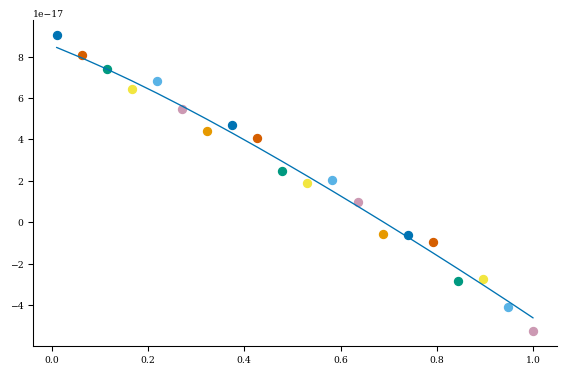

In [66]:
rhos = np.linspace(0.01, 1, 20)
theta = 0
zeta = 0

name = ["grad(|B|)", "b"]
i = 1
for r in rhos:
    data = inter1.evaluate(r, theta, zeta)
    plt.scatter(r, dot(data["b"], data["grad(|B|)"]))

grid = LinearGrid(rho=rhos, theta=theta, zeta=zeta)
b = eq.compute(name, grid=grid)
plt.plot(grid.nodes[:, 0], (dot(b["b"], b["grad(|B|)"])))

/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


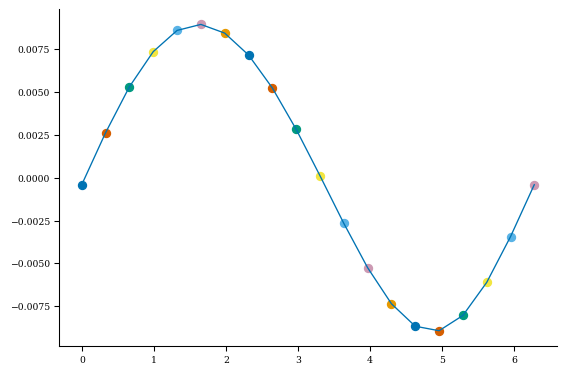

In [72]:
rho = 0.4
thetas = np.linspace(0, 2*np.pi, 20)
zeta = 2.14

name = ["grad(|B|)", "b"]
i = 2
for t in thetas:
    data = inter1.evaluate(rho, t, zeta)
    plt.scatter(t, dot(data["b"], data["grad(|B|)"]))

grid = LinearGrid(theta=thetas, rho=rho, zeta=zeta)
b = eq.compute(name, grid=grid)
plt.plot(grid.nodes[:, 1], (dot(b["b"], b["grad(|B|)"])))

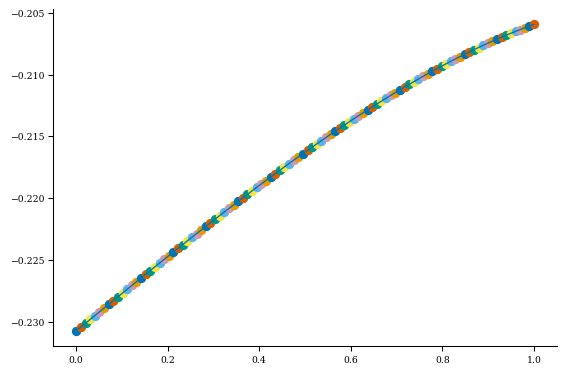

In [96]:
rhos = np.linspace(0.001, 1, 100)
theta = 0
zeta = 0

name = "e^theta*rho"
i = 2
for r in rhos:
    data = inter1.evaluate(r, theta, zeta)
    plt.scatter(r, data[name][i])

grid = LinearGrid(rho=rhos, theta=theta, zeta=zeta)
b = eq.compute(name, grid=grid)[name]
plt.plot(grid.nodes[:, 0], b[:, i])

/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


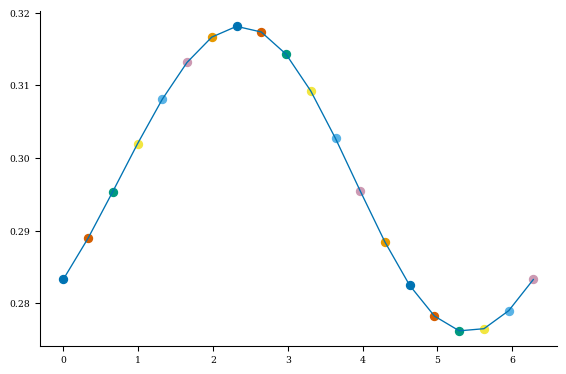

In [58]:
rho = 0.1
thetas = np.linspace(0, 2*np.pi, 20)
zeta = 0.4

name = "grad(|B|)"
i = 2
for t in thetas:
    data = inter1.evaluate(rho, t, zeta)
    plt.scatter(t, data[name][i])

grid = LinearGrid(theta=thetas, rho=rho, zeta=zeta)
b = eq.compute(name, grid=grid)[name]
plt.plot(grid.nodes[:, 1], b[:, i])

/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)
/CODES/DESC/desc/utils.py:572: UserWarning: Unequal number of field periods for grid 1 and basis 2.
  warnings.warn(msg, err)


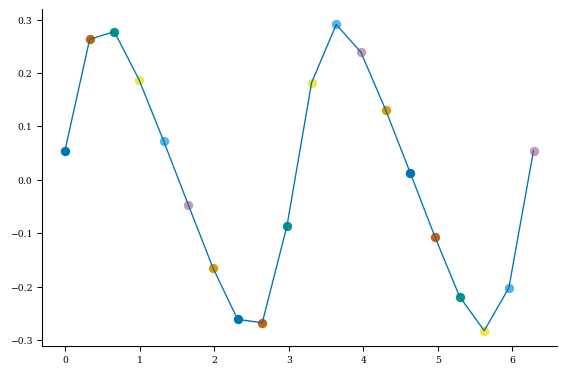

In [57]:
rho = 0.3
theta = 0.5
zetas = np.linspace(0, 2 * np.pi, 20)

name = "grad(|B|)"
i = 2
for z in zetas:
    data = inter1.evaluate(rho, theta, z)
    plt.scatter(z, data[name][i])

grid = LinearGrid(zeta=zetas, rho=rho, theta=theta)
b = eq.compute(name, grid=grid)[name]
plt.plot(grid.nodes[:, 2], b[:, i])

In [ ]:
LinearGrid(L=2, M=1, N=2).nodes